In [15]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = torch.device("cpu")

print(device)

import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

cpu


In this example we'll be using two types of pre-trained weights from torchaudio.
Some are fine-tuned for Automatic Speech Recognition task and the other ones are not fine-tuned.

Wav2Vec2(and HuBERT) models are trained in self-supervised manner. They are firstly trained with audio only for representation learning, then fine-tuned for a specific task with additional labels.

We'll be using a pre-trained models from the torch audio pipelines.

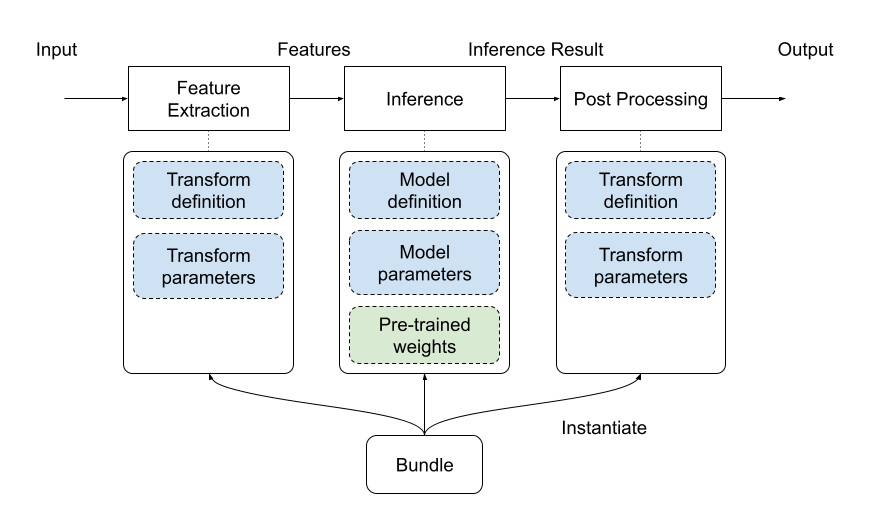

In [16]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate: ", bundle.sample_rate)
print("Labels:", bundle.get_labels())

model = bundle.get_model().to(device)
print(model.__class__)

Sample Rate:  16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [17]:
IPython.display.Audio(SPEECH_FILE)

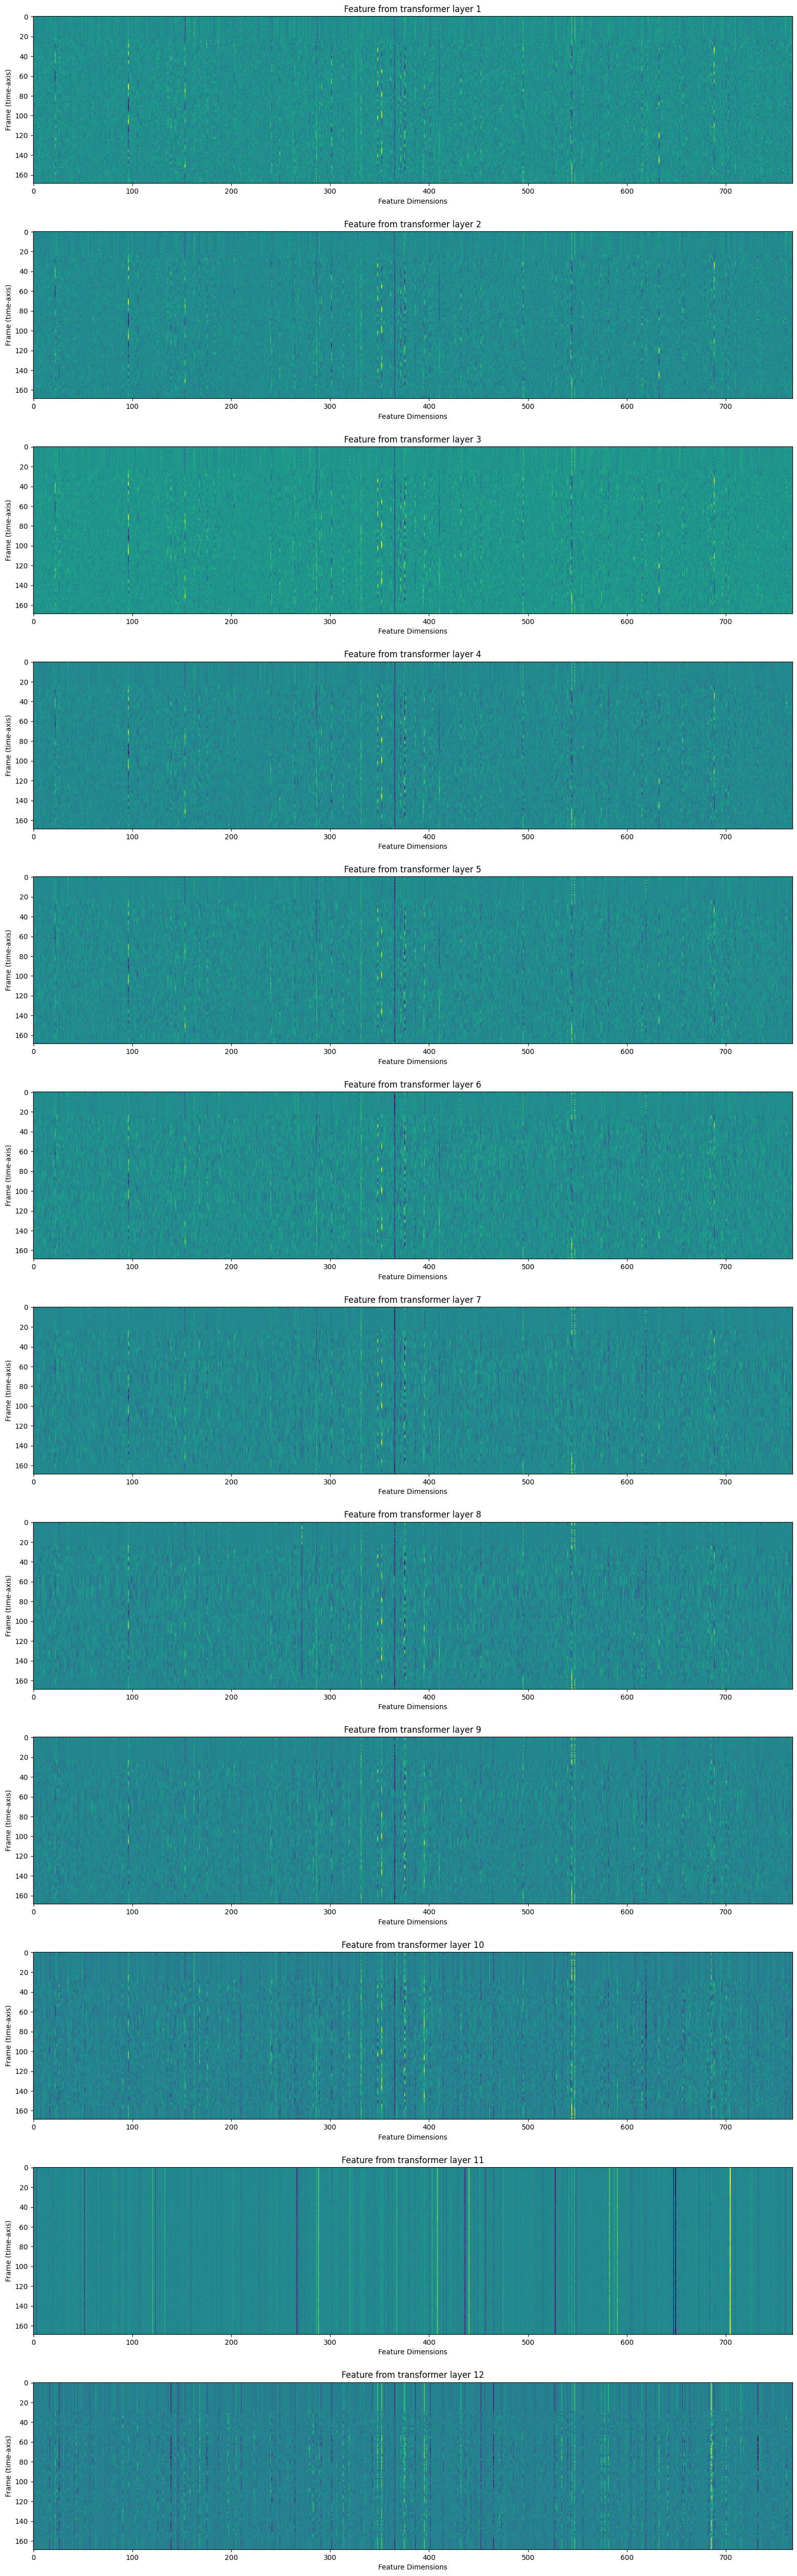

In [18]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
wavevorm = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

with torch.inference_mode():
    features,_ = model.extract_features(waveform)

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature Dimensions")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()


In [19]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


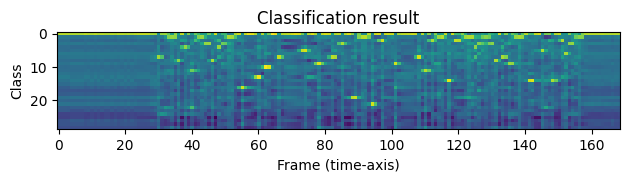

In [20]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [21]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank
    
    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [22]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
print(transcript)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
